In [12]:
import numpy as np
import math
from PIL import Image
import random


In [13]:
class camera:
    def __init__(self, fov: int, vertical_fov: int, resolution: tuple, location: tuple, direction: tuple, view_distance: tuple):
        self.fov = fov
        self.vertical_fov = vertical_fov
        self.resolution = resolution
        self.location = location
        self.direction = direction
        self.view_distance = view_distance

In [40]:
class mesh3D:

    def __init__(self, verticies: list, faces: list, center: tuple):
        self.verticies = verticies
        self.faces = faces
        self.center = center
        
    def global_cords(self):
        transformation_matrix = np.array([[1,0,0,self.center[0]],[0,1,0,self.center[1]],[0,0,1,self.center[2]],[0,0,0,1]])
        return [np.dot(transformation_matrix,point) for point in self.verticies]

    def reorient_to_camera(self, camera: camera, global_cords: list):
        transformation_matrix = np.array([[1,0,0,-camera.location[0]],[0,1,0,-camera.location[1]],[0,0,1,-camera.location[2]],[0,0,0,1]])
        x_rotation_matrix = np.array([[1,0,0,0],[0,math.cos(math.radians(-camera.direction[0])),-math.sin(math.radians(-camera.direction[0])),0],[0,math.sin(math.radians(-camera.direction[0])),math.cos(math.radians(-camera.direction[0])),0],[0,0,0,1]])
        y_rotation_matrix = np.array([[math.cos(math.radians(-camera.direction[1])),0,math.sin(math.radians(-camera.direction[1])),0],[0,1,0,0],[-math.sin(math.radians(-camera.direction[1])),0,math.cos(math.radians(-camera.direction[1])),0],[0,0,0,1]])
        z_rotation_matrix = np.array([[math.cos(math.radians(-camera.direction[2])),-math.sin(math.radians(-camera.direction[2])),0,0],[math.sin(math.radians(-camera.direction[2])),math.cos(math.radians(-camera.direction[2])),0,0],[0,0,1,0],[0,0,0,1]])
        return [np.dot(np.dot(np.dot(np.dot(point,transformation_matrix),x_rotation_matrix),y_rotation_matrix),z_rotation_matrix) for point in global_cords]

    def clipping(self, camera: camera, oriented_to_camera_verticies: list, faces: list):
        self.clipped = []
        x_limit, y_limit = math.sin(math.radians(camera.fov/2))/math.cos(math.radians(camera.fov/2)),math.sin(math.radians(camera.vertical_fov/2))/math.cos(math.radians(camera.vertical_fov/2))
        for face in faces:
            for point_idx in face:
                point = oriented_to_camera_verticies[point_idx]
                if camera.view_distance[0] <= point[2] <= camera.view_distance[1] and abs(point[0]/point[2]) <= x_limit and abs(point[1]/point[2]) <= y_limit:
                    self.clipped.append(face)
                    break
        return self.clipped

    def back_culling(self, oriented_to_camera_verticies: list, clipped: list):
        self.culled_faces = []
        for face in clipped:
            ax, ay, az, _ = oriented_to_camera_verticies[face[0]]
            bx, by, bz, _  = oriented_to_camera_verticies[face[1]]
            cx, cy, cz, _  = oriented_to_camera_verticies[face[2]]
            vector1 = np.array([bx-ax, by-ay, bz-az])
            vector2 = np.array([bx-cx, by-cy, bz-cz])
            angle = np.cross(vector1, vector2)
            angle = np.append(angle,0)
            if np.dot(angle, oriented_to_camera_verticies[face[1]]) <= 0:
                self.culled_faces.append(face)
        return self.culled_faces

    def perspective_projection(self, camera: camera, oriented_to_camera_verticies: list):
        aspect_ratio = camera.resolution[1]/camera.resolution[0]
        projection_matrix = np.array([[camera.view_distance[0]/math.tan(math.radians(camera.fov/2)),0,0,0],[0,camera.view_distance[0]/math.tan(math.radians(camera.vertical_fov/2)),0,0],[0,0,camera.view_distance[1]-camera.view_distance[0],-camera.view_distance[0]*camera.view_distance[0]],[0,0,1,0]])
        points_in_2d = []
        for vertex in oriented_to_camera_verticies:
            homogeneous_point = np.dot(vertex, projection_matrix)
            if homogeneous_point[3]:
                points_in_2d.append(homogeneous_point/homogeneous_point[3])
            else:
                points_in_2d.append(homogeneous_point)
        return points_in_2d

    def mesh_render(self, camera: camera, back_culling: bool = True):
        global_cords = self.global_cords()
        oriented_to_camera_verticies = self.reorient_to_camera(camera, global_cords)
        clipped = self.clipping(camera, self.faces, oriented_to_camera_verticies)
        if clipped:
            if back_culling:
                culled_faces = self.back_culling(oriented_to_camera_verticies, clipped)
            else:
                culled_faces = clipped
            return self.perspective_projection(camera, oriented_to_camera_verticies), culled_faces
        else: return False

    def rasterization(self, canvas: list, height_map: list, verticies: list, faces: list, color: tuple):
        resolutionX, resolutionY = len(canvas), len(canvas[0])
        verticies = [np.array([round((vertex[0]+1)*resolutionX/2),round((vertex[1]+1)*resolutionY/2),vertex[2],1]) for vertex in verticies]
        for face in faces:
            ax, ay, az, _ = verticies[face[0]]
            bx, by, bz, _  = verticies[face[1]]
            cx, cy, cz, _  = verticies[face[2]]
            vector1 = np.array([bx-ax, by-ay, bz-az])
            vector2 = np.array([bx-cx, by-cy, bz-cz])
            angle = np.cross(vector1, vector2)
            shape = np.zeros([resolutionX, resolutionY])
            for idx, point_idx in enumerate(face):
                for px,py,z in line_2d(verticies[point_idx]+1, verticies[face[idx-1]]):
                    if not (px < 0 or px > resolutionX-1 or py < 0 or py > resolutionY-1):
                        if True: #z >= height_map[int(px)][int(py)]:
                            canvas[int(px)][int(py)] = color
                            height_map[int(px)][int(py)] = z
                        shape[int(px)][int(py)] = 1
            #''''
            stack = [np.rint(sum(verticies[point_idx] for point_idx in face)/len(faces))]
            x_slope = (angle[0]/angle[2])
            y_slope = (angle[1]/angle[2])
            xc,yc,_,_ = stack[0]- verticies[face[0]]
            print(stack[0])
            stack[0][2] = verticies[face[0]][2] + x_slope*xc +yc*y_slope
            print(stack[0])
            print("---------------")
            while stack:
                x,y,z,_ = stack[0]
                x,y = round(x), round(y)
                if z >= height_map[x][y]:
                    canvas[x][y] = color
                    height_map[x][y] = z
                if not (x+1 < 0 or x+1 > resolutionX-1 or y < 0 or y > resolutionY-1):
                    if not shape[x+1][y]:
                        stack.append((x+1, y, z+x_slope, 1))
                        shape[x+1][y] = 1
                if not (x-1 < 0 or x-1 > resolutionX-1 or y < 0 or y > resolutionY-1):
                    if not shape[x-1][y]:
                        stack.append((x-1, y, z-x_slope, 1))
                        shape[x-1][y] = 1
                if not (x < 0 or x > resolutionX-1 or y+1 < 0 or y+1 > resolutionY-1):
                    if not shape[x][y+1]:
                        stack.append((x, y+1, z+y_slope, 1))
                        shape[x][y+1] = 1
                if not (x < 0 or x > resolutionX-1 or y-1 < 0 or y-1 > resolutionY-1):
                    if not shape[x][y-1]:
                        stack.append((x, y-1, z-y_slope, 1))
                        shape[x][y-1] = 1
                stack.pop(0)
                #'''
        return canvas

                            
        
        

            
            

In [15]:
def line_2d(point_1: tuple, point_2: tuple):
    x1, y1, z1, _ = point_1
    x2, y2, z2, _ = point_2
    difference_x = abs(x2 - x1)
    difference_y = abs(y2 - y1)
    difference_z = abs(z2 - z1)
    if x2 > x1:
        x_sign = 1
    else:
        x_sign = -1
    if y2 > y1:
        y_sign = 1
    else:
        y_sign = -1
    if z2 > z1:
        z_sign = 1
    else:
        z_sign = -1
    if max(difference_x,difference_y) == difference_x:
        y_error = 2*difference_y - difference_x
        z_error = 2*difference_z - difference_x
        yield (x1,y1,z1)
        while x1 != x2:
            x1 += x_sign
            if y_error >= 0:
                y1 += y_sign
                y_error -= 2 * difference_x
            y_error += 2 * difference_y 
            while z_error >= 0:
                z1 += z_sign
                z_error -= 2 * difference_x
            z_error += 2 * difference_z
            yield (x1,y1,z1)
    elif max(difference_x,difference_y) == difference_y:
        x_error = 2*difference_x - difference_y
        z_error = 2*difference_z - difference_x
        yield (x1,y1,z1)
        while y1 != y2:
            y1 += y_sign
            if x_error >= 0:
                x1 += x_sign
                x_error -= 2 * difference_y
            x_error += 2 * difference_x 
            while z_error >= 0:
                z1 += z_sign
                z_error -= 2 * difference_x
            z_error += 2 * difference_z
            yield (x1,y1,z1)


In [26]:
def create_cube_mesh(side_length: int, center: tuple, rotation: tuple):
    possible_diff = [side_length/2,-side_length/2]
    verticies = [np.array([xa,ya,za,1]) for xa in possible_diff for ya in possible_diff for za in possible_diff]
    x_rotation_matrix = np.array([[1,0,0,0],[0,math.cos(math.radians(rotation[0])),-math.sin(math.radians(rotation[0])),0],[0,math.sin(math.radians(rotation[0])),math.cos(math.radians(rotation[0])),0],[0,0,0,1]])
    y_rotation_matrix = np.array([[math.cos(math.radians(rotation[1])),0,math.sin(math.radians(rotation[1])),0],[0,1,0,0],[-math.sin(math.radians(rotation[1])),0,math.cos(math.radians(rotation[1])),0],[0,0,0,1]])
    z_rotation_matrix = np.array([[math.cos(math.radians(rotation[2])),-math.sin(math.radians(rotation[2])),0,0],[math.sin(math.radians(rotation[2])),math.cos(math.radians(rotation[2])),0,0],[0,0,1,0],[0,0,0,1]])
    #faces = [[0,1,2],[2,1,3],[6,4,2],[2,4,0],[4,5,0],[0,5,1],[7,5,6],[6,5,4],[3,7,2],[2,7,6],[3,7,1],[1,7,5]]
    faces = [[0,4,5,1],[0,2,3,1],[6,7,3,2],[4,6,7,5],[4,6,2,0],[7,5,1,3]]
    return mesh3D([np.dot(np.dot(np.dot(vertex,x_rotation_matrix),y_rotation_matrix),z_rotation_matrix) for vertex in verticies],faces,center)


In [17]:
def initialize_2dimage(dimensions: tuple, background_color: tuple) -> list:
    return [[background_color for _ in range(dimensions[1])] for _ in range(dimensions[0])]

In [18]:
def save_image(pixels: list, image_name: str):
    pixels = list(zip(*pixels))[::-1]
    array = np.array(pixels, dtype=np.uint8)
    new_image = Image.fromarray(array)
    display(new_image)
    new_image.save(image_name + '.png')

In [19]:
rs = lambda: random.randint(250,350)
rd = lambda: random.randint(590,600)
rn = lambda: random.choice([-1,1])*random.randint(35,600)
rr = lambda: random.randint(0,90)


In [42]:
canvas = initialize_2dimage((1000,1000),(0,0,0))
height_map = np.zeros([1000,1000])-1000
#create_cube_mesh(side_length: int, center: tuple, rotation: tuple)
meshes = [create_cube_mesh(100, (0,0,500),(rr(),rr(),rr())) for x in range(1)]
cam1 = camera(90,90,(1000,1000),
(0,0,0),(0,0,0),(1,1000))
for mesh in meshes:
    verticies = mesh.global_cords()
    points = mesh.perspective_projection(cam1,verticies)
    print(points[0])
    canvas = mesh.rasterization(canvas, height_map, points, mesh.faces, (255,255,255))
save_image(canvas, "cubes")  

[-1.35067319e-01 -1.12456813e-01 -9.99002074e+02  1.00000000e+00]
[ 321.  328. -666.    1.]
[ 321.          328.         -999.00237593    1.        ]
---------------


KeyboardInterrupt: 

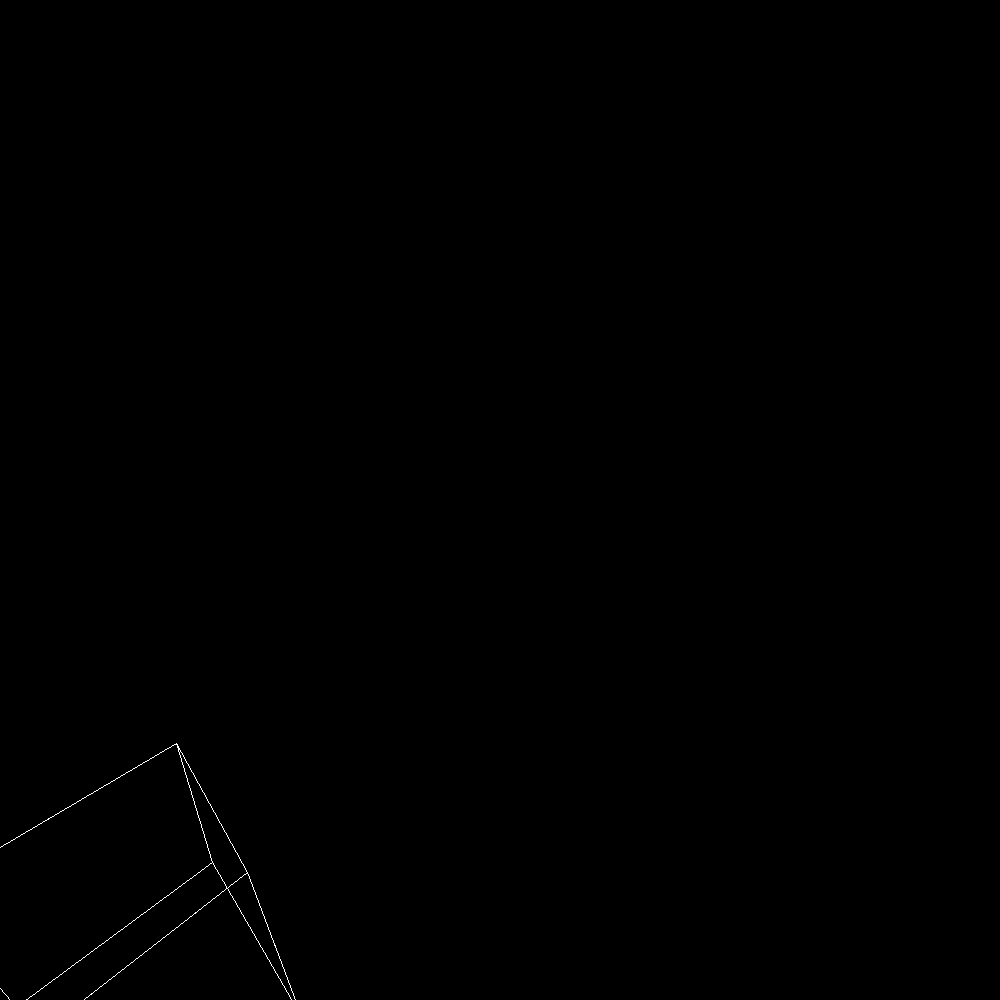

In [21]:

cam1 = camera(90,90,(1000,1000),(0,0,0),(0,0,0),(1,1000))

meshes = [create_cube_mesh(rs(), (rn(),rn(),rd()),(rr(),rr(),rr())) for x in range(1)]
enviornment = initialize_2dimage((1000,1000),(0,0,0))
for mesh in meshes:
    verticies = mesh.global_cords()
    points = mesh.perspective_projection(cam1,verticies)
    for face in mesh.faces:
        for idx, point in enumerate(face):
            point_1 = (points[point]+1)*500
            point_2 = (points[face[idx-1]]+1)*500
            z1 = point_1[2]
            z2 = point_2[2]
            point_1 = np.rint(point_1)
            point_2 = np.rint(point_2)
            point_1[2] = z1
            point_2[2] = z2
            for px, py, pz in line_2d(point_1, point_2):
                if not (px < 0 or px > 999 or py < 0 or py > 999):
                    enviornment[int(px)][int(py)] = (255,255,255)
            
save_image(enviornment, "cubes")  



